In [90]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('proj2.ok')

Assignment: proj2
OK, version v1.13.11



# Project 2: Spam/Ham Classification
## Feature Engineering, Logistic Regression, Cross Validation
## Due Date: Sunday 11/24/19, 11:59PM

**Collaboration Policy**

Data science is a collaborative activity. While you may talk with others about
the project, we ask that you **write your solutions individually**. If you do
discuss the assignments with others please **include their names** at the top
of your notebook.

**Collaborators**: *list collaborators here*

## This Assignment
In this project, you will use what you've learned in class to create a classifier that can distinguish spam (junk or commercial or bulk) emails from ham (non-spam) emails. In addition to providing some skeleton code to fill in, we will evaluate your work based on your model's accuracy and your written responses in this notebook.

After this project, you should feel comfortable with the following:

- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

## Warning
We've tried our best to filter the data for anything blatantly offensive as best as we can, but unfortunately there may still be some examples you may find in poor taste. If you encounter these examples and believe it is inappropriate for students, please let a TA know and we will try to remove it for future semesters. Thanks for your understanding!

# Part I - Initial Analysis

In [91]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading in the Data

In email classification, our goal is to classify emails as spam or not spam (referred to as "ham") using features generated from the text in the email. 

The dataset consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the test set contains 1000 unlabeled examples.

Run the following cells to load in the data into DataFrames.

The `train` DataFrame contains labeled data that you will use to train your model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. You will predict labels for these emails and submit your predictions to Kaggle for evaluation.

In [92]:
from utils import fetch_and_cache_gdrive
fetch_and_cache_gdrive('1SCASpLZFKCp2zek-toR3xeKX3DZnBSyp', 'train.csv')
fetch_and_cache_gdrive('1ZDFo9OTF96B5GP2Nzn8P8-AL7CTQXmC0', 'test.csv')

original_training_data = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

# Convert the emails to lower case as a first step to processing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

Using version already downloaded: Wed Nov 20 22:23:10 2019
MD5 hash of file: 0380c4cf72746622947b9ca5db9b8be8
Using version already downloaded: Wed Nov 20 22:23:11 2019
MD5 hash of file: a2e7abd8c7d9abf6e6fafc1d1f9ee6bf


,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


### Question 1a
First, let's check if our data contains any missing values. Fill in the cell below to print the number of NaN values in each column. If there are NaN values, replace them with appropriate filler values (i.e., NaN values in the `subject` or `email` columns should be replaced with empty strings). Print the number of NaN values in each column after this modification to verify that there are no NaN values left.

Note that while there are no NaN values in the `spam` column, we should be careful when replacing NaN labels. Doing so without consideration may introduce significant bias into our model when fitting.

*The provided test checks that there are no missing values in your dataset.*

<!--
BEGIN QUESTION
name: q1a
points: 1
-->

In [93]:
columns = original_training_data.columns
print("Before")
for each in columns: 
    nan_count = len(original_training_data[pd.isnull(original_training_data[each])])
    print(f" Column {each} NaN values =  {nan_count}")
    
original_training_data = original_training_data.fillna("")
print("After")
for each in columns: 
    nan_count = len(original_training_data[pd.isnull(original_training_data[each])])
    print(f" Column {each} NaN values =  {nan_count}")

Before
 Column id NaN values =  0
 Column subject NaN values =  6
 Column email NaN values =  0
 Column spam NaN values =  0
After
 Column id NaN values =  0
 Column subject NaN values =  0
 Column email NaN values =  0
 Column spam NaN values =  0


In [94]:
ok.grade("q1a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1b

In the cell below, print the text of the first ham and the first spam email in the original training set.

*The provided tests just ensure that you have assigned `first_ham` and `first_spam` to rows in the data, but only the hidden tests check that you selected the correct observations.*

<!--
BEGIN QUESTION
name: q1b
points: 1
-->

In [95]:
first_ham = original_training_data[original_training_data['spam']==0]['email'].values[0]
first_spam = original_training_data[original_training_data['spam']==1]['email'].values[0]
print(first_ham)
print(first_spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



In [96]:
ok.grade("q1b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 1c

Discuss one thing you notice that is different between the two emails that might relate to the identification of spam.

<!--
BEGIN QUESTION
name: q1c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

One thing to notice in both emails is format of the email. Ham email is well formated but the spam email includes all html tags and divs. Also notices that the word are not properly structured, this might be the case of filtering the bad words as mentioned in the top part of notebook to make it non offensive texts.

## Training Validation Split
The training data we downloaded is all the data we have available for both training models and **validating** the models that we train.  We therefore need to split the training data into separate training and validation datsets.  You will need this **validation data** to assess the performance of your classifier once you are finished training. Note that we set the seed (random_state) to 42. This will produce a pseudo-random sequence of random numbers that is the same for every student. **Do not modify this in the following questions, as our tests depend on this random seed.**

In [97]:
from sklearn.model_selection import train_test_split

train, val = train_test_split(original_training_data, test_size=0.1, random_state=42)

# Basic Feature Engineering

We would like to take the text of an email and predict whether the email is ham or spam. This is a *classification* problem, so we can use logistic regression to train a classifier. Recall that to train an logistic regression model we need a numeric feature matrix $X$ and a vector of corresponding binary labels $y$.  Unfortunately, our data are text, not numbers. To address this, we can create numeric features derived from the email text and use those features for logistic regression.

Each row of $X$ is an email. Each column of $X$ contains one feature for all the emails. We'll guide you through creating a simple feature, and you'll create more interesting ones when you are trying to increase your accuracy.

### Question 2

Create a function called `words_in_texts` that takes in a list of `words` and a pandas Series of email `texts`. It should output a 2-dimensional NumPy array containing one row for each email text. The row should contain either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example:

```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```

*The provided tests make sure that your function works correctly, so that you can use it for future questions.*

<!--
BEGIN QUESTION
name: q2
points: 3
-->

In [98]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    indicator_array = []
    for each_text in texts:
        result = []
        for each_word in words:
            if each_word in each_text:
                result.append(1)
            else:
                result.append(0)
        indicator_array.append(result)
    
    return np.array(indicator_array)

In [99]:
ok.grade("q2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



# Basic EDA

We need to identify some features that allow us to distinguish spam emails from ham emails. One idea is to compare the distribution of a single feature in spam emails to the distribution of the same feature in ham emails. If the feature is itself a binary indicator, such as whether a certain word occurs in the text, this amounts to comparing the proportion of spam emails with the word to the proportion of ham emails with the word.


The following plot (which was created using `sns.barplot`) compares the proportion of emails in each class containing a particular set of words. 

![training conditional proportions](./images/training_conditional_proportions.png "Class Conditional Proportions")

Hint:
- You can use DataFrame's `.melt` method to "unpivot" a DataFrame. See the following code cell for an example.

In [100]:
from IPython.display import display, Markdown
df = pd.DataFrame({
    'word_1': [1, 0, 1, 0],
    'word_2': [0, 1, 0, 1],
    'type': ['spam', 'ham', 'ham', 'ham']
})
display(Markdown("> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence."))
display(df);
display(Markdown("> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column"))
display(df.melt("type"))

> Our Original DataFrame has some words column and a type column. You can think of each row as a sentence, and the value of 1 or 0 indicates the number of occurances of the word in this sentence.

,word_1,word_2,type
0,1,0,spam
1,0,1,ham
2,1,0,ham
3,0,1,ham


> `melt` will turn columns into variale, notice how `word_1` and `word_2` become `variable`, their values are stored in the value column

,type,variable,value
0,spam,word_1,1
1,ham,word_1,0
2,ham,word_1,1
3,ham,word_1,0
4,spam,word_2,0
5,ham,word_2,1
6,ham,word_2,0
7,ham,word_2,1


### Question 3a

Create a bar chart like the one above comparing the proportion of spam and ham emails containing certain words. Choose a set of words that are different from the ones above, but also have different proportions for the two classes. Make sure to only consider emails from `train`.

<!--
BEGIN QUESTION
name: q3a
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

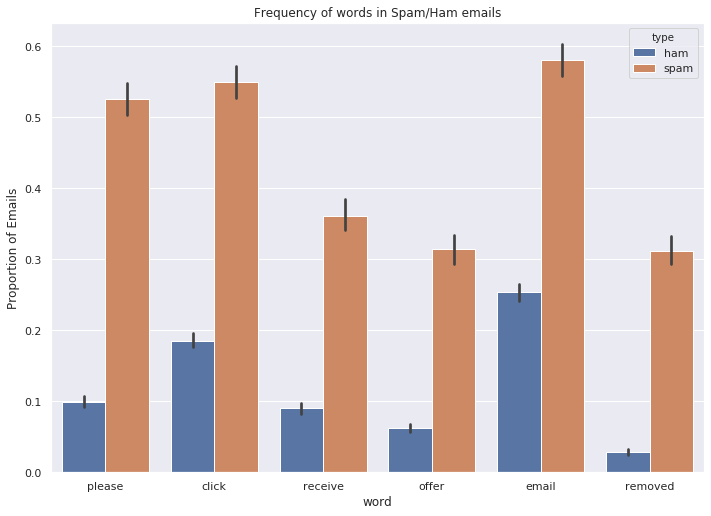

In [101]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
train=train.reset_index(drop=True) # We must do this in order to preserve the ordering of emails to labels for words_in_texts
words = ["please",'click','receive', 'offer','email','removed'] #selected words
result = words_in_texts(words,train['email'])
train_with_words = train.copy()

#creating type column fot df.melt
train_with_words['type'] = train_with_words['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')

#droping unnecessary columns
train_with_words = train_with_words.drop(columns=['id', 'subject','email','spam'])
#creating columns with the words
train_with_words['please'],train_with_words['click'],train_with_words['receive'],train_with_words['offer'],train_with_words['email'],train_with_words['removed'] = result[:,0],result[:,1],result[:,2],result[:,3],result[:,4],result[:,5]
train_with_words = train_with_words.melt("type")
train_with_words = train_with_words.rename(columns={"variable": "word"})

#barplot
sns.barplot(x = 'word', y = 'value', data= train_with_words, hue = 'type')
plt.ylabel("Proportion of Emails")
plt.title("Frequency of words in Spam/Ham emails");

When the feature is binary, it makes sense to compare its proportions across classes (as in the previous question). Otherwise, if the feature can take on numeric values, we can compare the distributions of these values for different classes. 

![training conditional densities](./images/training_conditional_densities2.png "Class Conditional Densities")


### Question 3b

Create a *class conditional density plot* like the one above (using `sns.distplot`), comparing the distribution of the length of spam emails to the distribution of the length of ham emails in the training set. Set the x-axis limit from 0 to 50000.

<!--
BEGIN QUESTION
name: q3b
manual: True
format: image
points: 2
-->
<!-- EXPORT TO PDF format:image -->

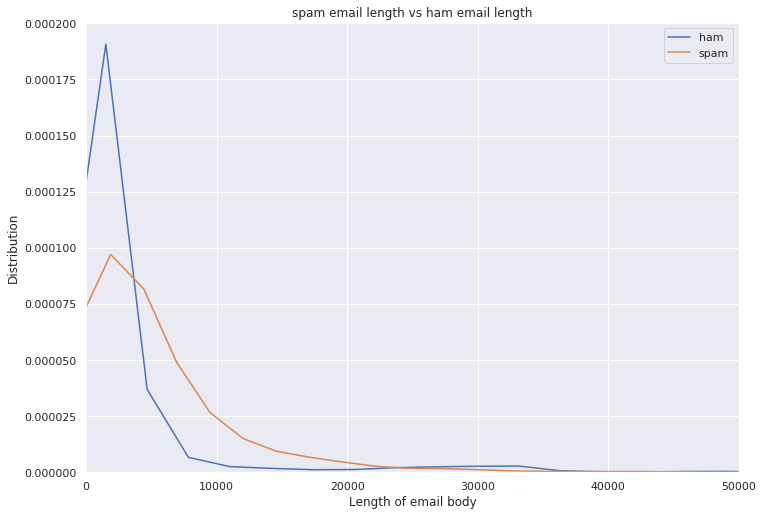

In [102]:
email_len = train.copy()
email_len['email_len'] = email_len['email'].str.len()
sns.distplot(email_len[email_len['spam'] == 0]['email_len'],label="ham",hist = False)
sns.distplot(email_len[email_len['spam'] == 1]['email_len'],label="spam", hist = False)
plt.xlim(right = 50000)
plt.xlim(left = 0)
plt.xlabel("Length of email body")
plt.ylabel("Distribution")
plt.title("spam email length vs ham email length");

# Basic Classification

Notice that the output of `words_in_texts(words, train['email'])` is a numeric matrix containing features for each email. This means we can use it directly to train a classifier!

### Question 4

We've given you 5 words that might be useful as features to distinguish spam/ham emails. Use these words as well as the `train` DataFrame to create two NumPy arrays: `X_train` and `Y_train`.

`X_train` should be a matrix of 0s and 1s created by using your `words_in_texts` function on all the emails in the training set.

`Y_train` should be a vector of the correct labels for each email in the training set.

*The provided tests check that the dimensions of your feature matrix (X) are correct, and that your features and labels are binary (i.e. consists of 0 and 1, no other values). It does not check that your function is correct; that was verified in a previous question.*
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [103]:
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = train['spam']

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]), 0    0
 1    0
 2    0
 3    0
 4    0
 Name: spam, dtype: int64)

In [104]:
ok.grade("q4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 5

Now that we have matrices, we can use to scikit-learn! Using the [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) classifier, train a logistic regression model using `X_train` and `Y_train`. Then, output the accuracy of the model (on the training data) in the cell below. You should get an accuracy around 0.75.

*The provided test checks that you initialized your logistic regression model correctly.*

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [105]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train,Y_train)
print("Training Accuracy: ", training_accuracy)

Training Accuracy:  0.7576201251164648


In [106]:
ok.grade("q5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



## Evaluating Classifiers

That doesn't seem too shabby! But the classifier you made above isn't as good as this might lead us to believe. First, we are evaluating accuracy on the training set, which may provide a misleading accuracy measure, especially if we used the training set to identify discriminative features. In future parts of this analysis, it will be safer to hold out some of our data for model validation and comparison.

Presumably, our classifier will be used for **filtering**, i.e. preventing messages labeled `spam` from reaching someone's inbox. There are two kinds of errors we can make:
- False positive (FP): a ham email gets flagged as spam and filtered out of the inbox.
- False negative (FN): a spam email gets mislabeled as ham and ends up in the inbox.

These definitions depend both on the true labels and the predicted labels. False positives and false negatives may be of differing importance, leading us to consider more ways of evaluating a classifier, in addition to overall accuracy:

**Precision** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FP}}$ of emails flagged as spam that are actually spam.

**Recall** measures the proportion $\frac{\text{TP}}{\text{TP} + \text{FN}}$ of spam emails that were correctly flagged as spam. 

**False-alarm rate** measures the proportion $\frac{\text{FP}}{\text{FP} + \text{TN}}$ of ham emails that were incorrectly flagged as spam. 

The following image might help:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="500px">

Note that a true positive (TP) is a spam email that is classified as spam, and a true negative (TN) is a ham email that is classified as ham.

### Question 6a

Suppose we have a classifier `zero_predictor` that always predicts 0 (never predicts positive). How many false positives and false negatives would this classifier have if it were evaluated on the training set and its results were compared to `Y_train`? Fill in the variables below (answers can be hard-coded):

*Tests in Question 6 only check that you have assigned appropriate types of values to each response variable, but do not check that your answers are correct.*

<!--
BEGIN QUESTION
name: q6a
points: 1
-->

In [107]:
y_hat = np.array([0 for i in range(len(Y_train))])
TP = sum((Y_train == y_hat) & (Y_train == 1))
FN = sum((Y_train != y_hat) & (Y_train == 1))

TN = sum((Y_train == y_hat) & (Y_train == 0))
FP = sum((Y_train != y_hat) & (Y_train == 0))
print(f'TP:{TP}, FN:{FN}, TN:{TN}, FP:{FP}')

TP:0, FN:1918, TN:5595, FP:0


In [108]:
zero_predictor_fp = 0
zero_predictor_fn = len(Y_train)-np.count_nonzero(Y_train == 0)
zero_predictor_fn

1918

In [109]:
ok.grade("q6a");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6b

What are the accuracy and recall of `zero_predictor` (classifies every email as ham) on the training set? Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6b
points: 1
-->

In [110]:
zero_predictor_acc = np.count_nonzero(Y_train == 0)/len(Y_train)
zero_predictor_recall = 0
zero_predictor_acc,zero_predictor_recall

(0.7447091707706642, 0)

In [111]:
ok.grade("q6b");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6c

Provide brief explanations of the results from 6a and 6b. Why do we observe each of these values (FP, FN, accuracy, recall)?

<!--
BEGIN QUESTION
name: q6c
manual: True
points: 2
-->
<!-- EXPORT TO PDF -->

In 6a since we are predicting everything as class 0(ham) that means we have false positive as 0 because we are never predicting 1 for any class and we don't have any chance of being wrong while predicting for class 1 since we are not predicting that class at all. False negative is 1918 as we can see since we are predicting everything as 0, there are 1918 class in the dataset that are 1 and we are predicting it as 0. 

This bring down to the number that we calculate in 6b, as we can see that our model accuracy is really high that is almost 75% but if you see the recall, it's 0 which means our model performance over to predict class 1 is really bad as it is not predicting class 1 at all. We cannot just see the model accuracy and say that model is good, we need to also see how it is performing well on classifying certain class in the model. Different research have different requirement to tune the value of recall, sometimes if you resstrictly don't want to misclassify your class 0, you want recall to be as high as you want and vice versa, but in our case above, since we are not predicting class 1 at all, our recall is 0 and model accuracy is only based on classifying all the points as 0.

### Question 6d

Compute the precision, recall, and false-alarm rate of the `LogisticRegression` classifier created and trained in Question 5. Do **NOT** use any `sklearn` functions.

<!--
BEGIN QUESTION
name: q6d
points: 2
-->

In [112]:
y_pred = model.predict(X_train)
TP1 = sum((Y_train == y_pred) & (Y_train == 1))
FN1 = sum((Y_train != y_pred) & (Y_train == 1))
TN1 = sum((Y_train == y_pred) & (Y_train == 0))
FP1 = sum((Y_train != y_pred) & (Y_train == 0))
print(f'TP:{TP1}, FN:{FN1}, TN:{TN1}, FP:{FP1}')

TP:219, FN:1699, TN:5473, FP:122


In [113]:
logistic_predictor_precision = TP1/(TP1+FP1)
logistic_predictor_recall = TP1/(TP1+FN1)
logistic_predictor_far = FP1/(FP1+TN1)
print(logistic_predictor_precision,logistic_predictor_recall,logistic_predictor_far)

0.6422287390029325 0.11418143899895725 0.021805183199285077


In [114]:
ok.grade("q6d");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



### Question 6e

Are there more false positives or false negatives when using the logistic regression classifier from Question 5?

<!--
BEGIN QUESTION
name: q6e
manual: True
points: 1
-->
<!-- EXPORT TO PDF -->

There are more false negative when using logistic regression as you can see the number calculated above or you can also see that recall is really low which means there are more false negative

### Question 6f

1. Our logistic regression classifier got 75.6% prediction accuracy (number of correct predictions / total). How does this compare with predicting 0 for every email?
1. Given the word features we gave you above, name one reason this classifier is performing poorly. Hint: Think about how prevalent these words are in the email set.
1. Which of these two classifiers would you prefer for a spam filter and why? Describe your reasoning and relate it to at least one of the evaluation metrics you have computed so far.

<!--
BEGIN QUESTION
name: q6f
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

1. The accuracy of logistic regression classifier is based on the data it correctly classifies class 1 and class 0 over the total number of data in the training set where as if you see the predicting 0 model, there is no class 1 prediction and hence it is just the total correct prediction of class 0 over the total traing set and since our training set had majority non spam emails the accuracy of both the models are pretty close to each other.

2. The word that we are used are so common that it can be used in a ham email often too, so imagine someone sending an important email using those words(say email from your bank or banker, you getting email from your doctor regarding your prescription,etc) would be marked as spam and never arrives in the inbox which is bad.

3. I would prefer predicting 0 model because when you see the the false alarm rate, there are almost 4% email that are classified as spam and of those 4% email, when you see the actual number, it is 220 so 220 out of 7513 emails are being moved out of inbox, and that's a pretty big email where a lot of important emails could fall. I would rather classify everything as 0 and even get the spam emain in my inbox and move it manually to trash rather than losing the important email without my knowledge with the model prediction. 
3. In our case, i would prefer the Logistic regression model. Not just because it's accuracy is higher than the zero predictor also it has higher recall thank the zero predictor meaning it has higher the proportion of spam emails that were correctly flagged as spam than the zero predictor. The zero predictor is bad because it has higher accuracy just because turns out that out dataset had majority ham email, if it was the other way, our accuracy would drop but on the other model, it wouldn't change by that much.


# Part II - Moving Forward

With this in mind, it is now your task to make the spam filter more accurate. In order to get full credit on the accuracy part of this assignment, you must get at least **88%** accuracy on the test set. To see your accuracy on the test set, you will use your classifier to predict every email in the `test` DataFrame and upload your predictions to Kaggle.

**Kaggle limits you to four submissions per day**. This means you should start early so you have time if needed to refine your model. You will be able to see your accuracy on the entire set when submitting to Kaggle (the accuracy that will determine your score for question 10).

Here are some ideas for improving your model:

1. Finding better features based on the email text. Some example features are:
    1. Number of characters in the subject / body
    1. Number of words in the subject / body
    1. Use of punctuation (e.g., how many '!' were there?)
    1. Number / percentage of capital letters 
    1. Whether the email is a reply to an earlier email or a forwarded email
1. Finding better (and/or more) words to use as features. Which words are the best at distinguishing emails? This requires digging into the email text itself. 
1. Better data processing. For example, many emails contain HTML as well as text. You can consider extracting out the text from the HTML to help you find better words. Or, you can match HTML tags themselves, or even some combination of the two.
1. Model selection. You can adjust parameters of your model (e.g. the regularization parameter) to achieve higher accuracy. Recall that you should use cross-validation to do feature and model selection properly! Otherwise, you will likely overfit to your training data.

You may use whatever method you prefer in order to create features, but **you are not allowed to import any external feature extraction libraries**. In addition, **you are only allowed to train logistic regression models**. No random forests, k-nearest-neighbors, neural nets, etc.

We have not provided any code to do this, so feel free to create as many cells as you need in order to tackle this task. However, answering questions 7, 8, and 9 should help guide you.

---

**Note:** *You should use the **validation data** to evaluate your model and get a better sense of how it will perform on the Kaggle evaluation.*

---

In [115]:
string = ""
for i in train['email'].values:
    string = string + i + " "

In [116]:
from collections import Counter
x = Counter(string.split())
test_word = []
for i in x.most_common()[90:495]:
    test_word.append(i[0])

In [117]:
def design_matrix_converter(words, texts):
    '''
    Args:
        words (list-like): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    #exc_count = texts.str.count('!').values
    indicator_array = []
    #count = 0
    for each_text in texts:
        result = []
        result.append(len(each_text))
        for each_word in words:
            if each_word in each_text:
                result.append(1)
            else:
                result.append(0)
        #result.append(exc_count[count])
        #count+=1
        indicator_array.append(result)
    
    return np.array(indicator_array)

In [118]:
#Model iteration on using different set of feature and it's acuracy on training set and validation set
def feature_select(x_train,y_train):
    candidate_Cs1 = np.hstack(([1e9], 1 / 10.0 ** np.linspace(-5, 5, 11)))
    modelcv1 = LogisticRegressionCV(Cs=candidate_Cs1, solver='lbfgs')
    modelcv1.fit(x_train, y_train)
    y_hat1 = modelcv1.predict(x_train)
    print(f'Number of feature = {len(x_train[0])}')
    print(f'accuracy: {np.round(sum(y_hat1 == y_train)/ len(y_train),4)}')
    mat = design_matrix_converter(test_word[:len(x_train[0])],val['email'])[:,:len(x_train[0])]
    y_pred = modelcv1.predict(mat)
    acc = sum(val['spam'] == y_pred)/ len(val['spam'])
    print(f'val accuracy: {acc}')
    TP2 = sum((y_train == y_hat1) & (y_train == 1))
    FN2 = sum((y_train != y_hat1) & (y_train == 1))
    TN2 = sum((y_train == y_hat1) & (y_train == 0))
    FP2 = sum((y_train != y_hat1) & (y_train == 0))
    print(f'TP:{TP2}, FN:{FN2}, TN:{TN2}, FP:{FP2}')
    logisticcv_predictor_precision = np.round(TP2/(TP2+FP2),2)
    logisticcv_predictor_recall = np.round(TP2/(TP2+FN2),2)
    logisticcv_predictor_far = np.round(FP2/(FP2+TN2),2)
    print(f'logisticcv_predictor_precision: {logisticcv_predictor_precision}, \nlogisticcv_predictor_recall: {logisticcv_predictor_recall},\nlogisticcv_predictor_far: {logisticcv_predictor_far}')
    print("\n")

In [83]:
for i in range(1,len(X_train1[0])):
    feature_select(X_train1[:,:i],Y_train1)

Number of feature = 1
accuracy: 0.7439
val accuracy: 0.7365269461077845
TP:21, FN:1897, TN:5568, FP:27
logisticcv_predictor_precision: 0.44, 
logisticcv_predictor_recall: 0.01,
logisticcv_predictor_far: 0.0


Number of feature = 2
accuracy: 0.7436
val accuracy: 0.7365269461077845
TP:19, FN:1899, TN:5568, FP:27
logisticcv_predictor_precision: 0.41, 
logisticcv_predictor_recall: 0.01,
logisticcv_predictor_far: 0.0


Number of feature = 3
accuracy: 0.7438
val accuracy: 0.7365269461077845
TP:19, FN:1899, TN:5569, FP:26
logisticcv_predictor_precision: 0.42, 
logisticcv_predictor_recall: 0.01,
logisticcv_predictor_far: 0.0


Number of feature = 4
accuracy: 0.7436
val accuracy: 0.7365269461077845
TP:18, FN:1900, TN:5569, FP:26
logisticcv_predictor_precision: 0.41, 
logisticcv_predictor_recall: 0.01,
logisticcv_predictor_far: 0.0


Number of feature = 5
accuracy: 0.7436
val accuracy: 0.7365269461077845
TP:21, FN:1897, TN:5566, FP:29
logisticcv_predictor_precision: 0.42, 
logisticcv_predictor_r

Number of feature = 40
accuracy: 0.8821
val accuracy: 0.8766467065868263
TP:1205, FN:713, TN:5422, FP:173
logisticcv_predictor_precision: 0.87, 
logisticcv_predictor_recall: 0.63,
logisticcv_predictor_far: 0.03


Number of feature = 41
accuracy: 0.8838
val accuracy: 0.8754491017964072
TP:1209, FN:709, TN:5431, FP:164
logisticcv_predictor_precision: 0.88, 
logisticcv_predictor_recall: 0.63,
logisticcv_predictor_far: 0.03


Number of feature = 42
accuracy: 0.8805
val accuracy: 0.8730538922155688
TP:1201, FN:717, TN:5414, FP:181
logisticcv_predictor_precision: 0.87, 
logisticcv_predictor_recall: 0.63,
logisticcv_predictor_far: 0.03


Number of feature = 43
accuracy: 0.8895
val accuracy: 0.8826347305389222
TP:1248, FN:670, TN:5435, FP:160
logisticcv_predictor_precision: 0.89, 
logisticcv_predictor_recall: 0.65,
logisticcv_predictor_far: 0.03


Number of feature = 44
accuracy: 0.8897
val accuracy: 0.8802395209580839
TP:1261, FN:657, TN:5423, FP:172
logisticcv_predictor_precision: 0.88, 
log

Number of feature = 79
accuracy: 0.9163
val accuracy: 0.9137724550898204
TP:1471, FN:447, TN:5413, FP:182
logisticcv_predictor_precision: 0.89, 
logisticcv_predictor_recall: 0.77,
logisticcv_predictor_far: 0.03


Number of feature = 80
accuracy: 0.9169
val accuracy: 0.9101796407185628
TP:1463, FN:455, TN:5426, FP:169
logisticcv_predictor_precision: 0.9, 
logisticcv_predictor_recall: 0.76,
logisticcv_predictor_far: 0.03


Number of feature = 81
accuracy: 0.9184
val accuracy: 0.9089820359281438
TP:1496, FN:422, TN:5404, FP:191
logisticcv_predictor_precision: 0.89, 
logisticcv_predictor_recall: 0.78,
logisticcv_predictor_far: 0.03


Number of feature = 82
accuracy: 0.9217
val accuracy: 0.9173652694610779
TP:1515, FN:403, TN:5410, FP:185
logisticcv_predictor_precision: 0.89, 
logisticcv_predictor_recall: 0.79,
logisticcv_predictor_far: 0.03


Number of feature = 83
accuracy: 0.922
val accuracy: 0.918562874251497
TP:1509, FN:409, TN:5418, FP:177
logisticcv_predictor_precision: 0.9, 
logisti

Number of feature = 118
accuracy: 0.9341
val accuracy: 0.9245508982035928
TP:1576, FN:342, TN:5442, FP:153
logisticcv_predictor_precision: 0.91, 
logisticcv_predictor_recall: 0.82,
logisticcv_predictor_far: 0.03


Number of feature = 119
accuracy: 0.9421
val accuracy: 0.9281437125748503
TP:1639, FN:279, TN:5439, FP:156
logisticcv_predictor_precision: 0.91, 
logisticcv_predictor_recall: 0.85,
logisticcv_predictor_far: 0.03


Number of feature = 120
accuracy: 0.9377
val accuracy: 0.9209580838323354
TP:1606, FN:312, TN:5439, FP:156
logisticcv_predictor_precision: 0.91, 
logisticcv_predictor_recall: 0.84,
logisticcv_predictor_far: 0.03


Number of feature = 121
accuracy: 0.9325
val accuracy: 0.9209580838323354
TP:1558, FN:360, TN:5448, FP:147
logisticcv_predictor_precision: 0.91, 
logisticcv_predictor_recall: 0.81,
logisticcv_predictor_far: 0.03


Number of feature = 122
accuracy: 0.9464
val accuracy: 0.9305389221556887
TP:1659, FN:259, TN:5451, FP:144
logisticcv_predictor_precision: 0.92,

Number of feature = 157
accuracy: 0.9617
val accuracy: 0.9449101796407186
TP:1753, FN:165, TN:5472, FP:123
logisticcv_predictor_precision: 0.93, 
logisticcv_predictor_recall: 0.91,
logisticcv_predictor_far: 0.02


Number of feature = 158
accuracy: 0.9599
val accuracy: 0.948502994011976
TP:1741, FN:177, TN:5471, FP:124
logisticcv_predictor_precision: 0.93, 
logisticcv_predictor_recall: 0.91,
logisticcv_predictor_far: 0.02


Number of feature = 159
accuracy: 0.9601
val accuracy: 0.9425149700598803
TP:1729, FN:189, TN:5484, FP:111
logisticcv_predictor_precision: 0.94, 
logisticcv_predictor_recall: 0.9,
logisticcv_predictor_far: 0.02


Number of feature = 160
accuracy: 0.9579
val accuracy: 0.9437125748502994
TP:1730, FN:188, TN:5467, FP:128
logisticcv_predictor_precision: 0.93, 
logisticcv_predictor_recall: 0.9,
logisticcv_predictor_far: 0.02


Number of feature = 161
accuracy: 0.9623
val accuracy: 0.9461077844311377
TP:1760, FN:158, TN:5470, FP:125
logisticcv_predictor_precision: 0.93, 
l

Number of feature = 196
accuracy: 0.9669
val accuracy: 0.9520958083832335
TP:1776, FN:142, TN:5488, FP:107
logisticcv_predictor_precision: 0.94, 
logisticcv_predictor_recall: 0.93,
logisticcv_predictor_far: 0.02


Number of feature = 197
accuracy: 0.9626
val accuracy: 0.9508982035928144
TP:1755, FN:163, TN:5477, FP:118
logisticcv_predictor_precision: 0.94, 
logisticcv_predictor_recall: 0.92,
logisticcv_predictor_far: 0.02


Number of feature = 198
accuracy: 0.9669
val accuracy: 0.9473053892215569
TP:1777, FN:141, TN:5487, FP:108
logisticcv_predictor_precision: 0.94, 
logisticcv_predictor_recall: 0.93,
logisticcv_predictor_far: 0.02


Number of feature = 199
accuracy: 0.963
val accuracy: 0.9497005988023952
TP:1746, FN:172, TN:5489, FP:106
logisticcv_predictor_precision: 0.94, 
logisticcv_predictor_recall: 0.91,
logisticcv_predictor_far: 0.02


Number of feature = 200
accuracy: 0.9621
val accuracy: 0.9508982035928144
TP:1750, FN:168, TN:5478, FP:117
logisticcv_predictor_precision: 0.94, 

Number of feature = 235
accuracy: 0.9689
val accuracy: 0.9616766467065868
TP:1769, FN:149, TN:5510, FP:85
logisticcv_predictor_precision: 0.95, 
logisticcv_predictor_recall: 0.92,
logisticcv_predictor_far: 0.02


Number of feature = 236
accuracy: 0.9662
val accuracy: 0.9497005988023952
TP:1760, FN:158, TN:5499, FP:96
logisticcv_predictor_precision: 0.95, 
logisticcv_predictor_recall: 0.92,
logisticcv_predictor_far: 0.02


Number of feature = 237
accuracy: 0.967
val accuracy: 0.9497005988023952
TP:1761, FN:157, TN:5504, FP:91
logisticcv_predictor_precision: 0.95, 
logisticcv_predictor_recall: 0.92,
logisticcv_predictor_far: 0.02


Number of feature = 238
accuracy: 0.972
val accuracy: 0.9604790419161676
TP:1794, FN:124, TN:5509, FP:86
logisticcv_predictor_precision: 0.95, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.02


Number of feature = 239
accuracy: 0.9683
val accuracy: 0.9568862275449102
TP:1775, FN:143, TN:5500, FP:95
logisticcv_predictor_precision: 0.95, 
logis

Number of feature = 274
accuracy: 0.973
val accuracy: 0.962874251497006
TP:1800, FN:118, TN:5510, FP:85
logisticcv_predictor_precision: 0.95, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.02


Number of feature = 275
accuracy: 0.9727
val accuracy: 0.9616766467065868
TP:1787, FN:131, TN:5521, FP:74
logisticcv_predictor_precision: 0.96, 
logisticcv_predictor_recall: 0.93,
logisticcv_predictor_far: 0.01


Number of feature = 276
accuracy: 0.9742
val accuracy: 0.9640718562874252
TP:1804, FN:114, TN:5515, FP:80
logisticcv_predictor_precision: 0.96, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.01


Number of feature = 277
accuracy: 0.9735
val accuracy: 0.9640718562874252
TP:1800, FN:118, TN:5514, FP:81
logisticcv_predictor_precision: 0.96, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.01


Number of feature = 278
accuracy: 0.9743
val accuracy: 0.9604790419161676
TP:1800, FN:118, TN:5520, FP:75
logisticcv_predictor_precision: 0.96, 
logis

Number of feature = 313
accuracy: 0.9752
val accuracy: 0.9616766467065868
TP:1803, FN:115, TN:5524, FP:71
logisticcv_predictor_precision: 0.96, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.01


Number of feature = 314
accuracy: 0.9698
val accuracy: 0.9652694610778443
TP:1796, FN:122, TN:5490, FP:105
logisticcv_predictor_precision: 0.94, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.02


Number of feature = 315
accuracy: 0.9743
val accuracy: 0.962874251497006
TP:1804, FN:114, TN:5516, FP:79
logisticcv_predictor_precision: 0.96, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.01


Number of feature = 316
accuracy: 0.9764
val accuracy: 0.962874251497006
TP:1812, FN:106, TN:5524, FP:71
logisticcv_predictor_precision: 0.96, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.01


Number of feature = 317
accuracy: 0.975
val accuracy: 0.9664670658682635
TP:1805, FN:113, TN:5520, FP:75
logisticcv_predictor_precision: 0.96, 
logis

Number of feature = 352
accuracy: 0.9791
val accuracy: 0.9688622754491018
TP:1819, FN:99, TN:5537, FP:58
logisticcv_predictor_precision: 0.97, 
logisticcv_predictor_recall: 0.95,
logisticcv_predictor_far: 0.01


Number of feature = 353
accuracy: 0.9798
val accuracy: 0.9640718562874252
TP:1819, FN:99, TN:5542, FP:53
logisticcv_predictor_precision: 0.97, 
logisticcv_predictor_recall: 0.95,
logisticcv_predictor_far: 0.01


Number of feature = 354
accuracy: 0.9759
val accuracy: 0.9640718562874252
TP:1811, FN:107, TN:5521, FP:74
logisticcv_predictor_precision: 0.96, 
logisticcv_predictor_recall: 0.94,
logisticcv_predictor_far: 0.01


Number of feature = 355
accuracy: 0.9799
val accuracy: 0.9724550898203593
TP:1820, FN:98, TN:5542, FP:53
logisticcv_predictor_precision: 0.97, 
logisticcv_predictor_recall: 0.95,
logisticcv_predictor_far: 0.01


Number of feature = 356
accuracy: 0.9791
val accuracy: 0.9760479041916168
TP:1819, FN:99, TN:5537, FP:58
logisticcv_predictor_precision: 0.97, 
logisti

Number of feature = 391
accuracy: 0.9842
val accuracy: 0.9724550898203593
TP:1848, FN:70, TN:5546, FP:49
logisticcv_predictor_precision: 0.97, 
logisticcv_predictor_recall: 0.96,
logisticcv_predictor_far: 0.01


Number of feature = 392
accuracy: 0.9851
val accuracy: 0.9736526946107784
TP:1858, FN:60, TN:5543, FP:52
logisticcv_predictor_precision: 0.97, 
logisticcv_predictor_recall: 0.97,
logisticcv_predictor_far: 0.01


Number of feature = 393
accuracy: 0.9842
val accuracy: 0.9736526946107784
TP:1850, FN:68, TN:5544, FP:51
logisticcv_predictor_precision: 0.97, 
logisticcv_predictor_recall: 0.96,
logisticcv_predictor_far: 0.01


Number of feature = 394
accuracy: 0.9846
val accuracy: 0.9736526946107784
TP:1847, FN:71, TN:5550, FP:45
logisticcv_predictor_precision: 0.98, 
logisticcv_predictor_recall: 0.96,
logisticcv_predictor_far: 0.01


Number of feature = 395
accuracy: 0.9842
val accuracy: 0.9724550898203593
TP:1855, FN:63, TN:5539, FP:56
logisticcv_predictor_precision: 0.97, 
logistic

In [119]:
#The Final Model
from sklearn.linear_model import LogisticRegressionCV
X_train1 = design_matrix_converter(test_word, train['email'])
Y_train1 = train['spam']
candidate_Cs = np.hstack(([1e9], 1 / 10.0 ** np.linspace(-5, 5, 11)))
modelcv = LogisticRegressionCV(Cs=candidate_Cs, solver='lbfgs')
modelcv.fit(X_train1, Y_train1)
y_hat1 = modelcv.predict(X_train1)
print(f'accuracy: {np.round(sum(y_hat1 == Y_train1)/ len(Y_train1),4)}')

accuracy: 0.9888


In [120]:
TP2 = sum((Y_train1 == y_hat1) & (Y_train1 == 1))
FN2 = sum((Y_train1 != y_hat1) & (Y_train1 == 1))
TN2 = sum((Y_train1 == y_hat1) & (Y_train1 == 0))
FP2 = sum((Y_train1 != y_hat1) & (Y_train1 == 0))
print(f'TP:{TP2}, FN:{FN2}, TN:{TN2}, FP:{FP2}')
logisticcv_predictor_precision = np.round(TP2/(TP2+FP2),2)
logisticcv_predictor_recall = np.round(TP2/(TP2+FN2),2)
logisticcv_predictor_far = np.round(FP2/(FP2+TN2),2)
print(f'logisticcv_predictor_precision: {logisticcv_predictor_precision}, \nlogisticcv_predictor_recall: {logisticcv_predictor_recall},\nlogisticcv_predictor_far: {logisticcv_predictor_far}')


TP:1877, FN:41, TN:5552, FP:43
logisticcv_predictor_precision: 0.98, 
logisticcv_predictor_recall: 0.98,
logisticcv_predictor_far: 0.01


In [121]:
y_pred = modelcv.predict(design_matrix_converter(test_word, val['email']))
acc = sum(val['spam'] == y_pred)/ len(val['spam'])
print(f'accuracy: {acc}')

accuracy: 0.9772455089820359


### Question 7: Feature/Model Selection Process

In this following cell, describe the process of improving your model. You should use at least 2-3 sentences each to address the follow questions:

1. How did you find better features for your model?
2. What did you try that worked / didn't work?
3. What was surprising in your search for good features?

<!--
BEGIN QUESTION
name: q7
manual: True
points: 6
-->
<!-- EXPORT TO PDF -->

1. First i used the counter library from python and counted each frequencies of words in email body and ploted the words with spam vs ham to see the distribution, going through those frequencies i picked the most occurance of 15 words to use as feature in the model with the help of counter library. The accuracy got to around 86%,  after that to tune it further i noticed from previous plot on the distribution of ham/spam email length and used that feature as well as spam email length often tends to be slightly longer than the ham email from the distribution and i was able to get the accuracy of 89%. Adding more to it, i submitted it to kaggle and got accuracy of 88.6 % but everyone had higher score and i came back to the model and exploited the python counter function further more. I sorted the word frequencies and ficked the 407 feature and train the model on iteration using from just one feature to all the feature that i randomly selected to see how acruacy changed. I noticed the more feature i was using the more accuracy changed and i picked the set of feature where it gave least amount of false negative where no very less number of ham email are classified as spam. Since i was using regularization i knew the model won't overfitt so again i ran the model on test data and submitted it to kaggle and now have an accuracy of 99%.

2. I tried looking at the distribution of words in spam email and picked the most words that are common in spam email and it worked, i tried regularization logistic regression which also worked and at the end to get to the required accuracy i tried the length of the email body as a feature which worked. Among many things that worked, previously i picked few words and ran logistic regression. It was giving me 84-85% accuracy but as i added more words to get to higher accuracy, the model seem to overfit and accuracy started dropping and than i switched to regularization logistic regression and it worked amazingly and the more words/feature i added, the accuracy improved as regularization avoided my model from overfitting. I also tried using number of occurance of characters like ! and $ but the accuracy didn't changed so i ended up not using it. Comming back to this question now since i added almost 401 feature after first submission, now the model accuracy increased a lot than before. adding more feature worked well and actually improved precision,recall and false alarm rate as well.

3. While doing this assignment, i created two model to compare how the model differentiate. One was normal Logistic Regression and one with Regularization. The surprising thing i found out was when i added more feature in normal logistic regression the accuracy started dropping and also it was performing poor in validation data but when i switched to regularization logistic regression i was able to add more feature as i think was appropriate and was able to increase the accuracy and also there was not much difference in result from training set vs validation set. I also noticed that the length of email worked really well even without changin the scale of measurement becase the length was in thousands. This was a really fun exercise and i learned that how encoding occurance of each words and creating a design matrix, we were able to predict if a email is spam or not using logistic regression. This is amazing how even using 407 feature, the model did quite great on test data, i am eager to see how well is it gona perform on the hidden test data.

### Question 8: EDA

In the cell below, show a visualization that you used to select features for your model. Include

1. A plot showing something meaningful about the data that helped you during feature selection, model selection, or both.
2. Two or three sentences describing what you plotted and its implications with respect to your features.

Feel to create as many plots as you want in your process of feature selection, but select one for the response cell below.

**You should not just produce an identical visualization to question 3.** Specifically, don't show us a bar chart of proportions, or a one-dimensional class-conditional density plot. Any other plot is acceptable, as long as it comes with thoughtful commentary. Here are some ideas:

1. Consider the correlation between multiple features (look up correlation plots and `sns.heatmap`). 
1. Try to show redundancy in a group of features (e.g. `body` and `html` might co-occur relatively frequently, or you might be able to design a feature that captures all html tags and compare it to these). 
1. Visualize which words have high or low values for some useful statistic.
1. Visually depict whether spam emails tend to be wordier (in some sense) than ham emails.

Generate your visualization in the cell below and provide your description in a comment.

<!--
BEGIN QUESTION
name: q8
manual: True
format: image
points: 6
-->
<!-- EXPORT TO PDF format:image -->

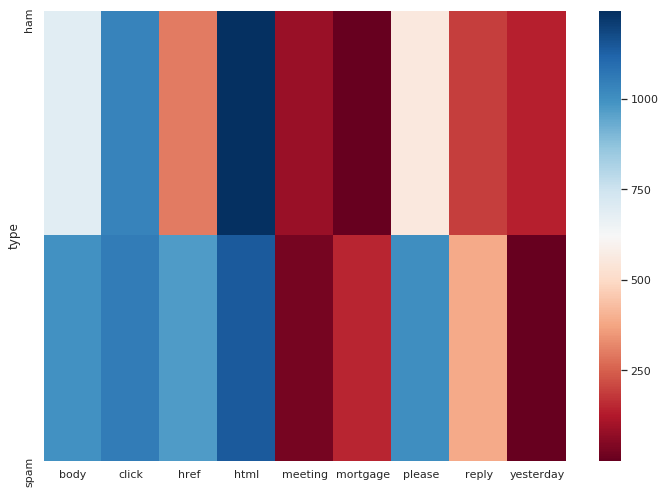

In [122]:
#Comments
#Below i have ploted heatmap of some of the words i used and some of the words i didn't used
#as you can see i picked words like bills, mortgage,please,click reply because when you see the relation 
#of those numbers between two classes, they are very rarely used in the ham emails of but frequently
#used in the emails of spam as indicated by the color score in heatmap 
#Also you can see html, href co-occur in both classes because the distribution of those word frequency is quite high
# in both classes(The number in heatmap scale is from 500-1000) even though there is a little more in spam class.
#Also words like meeting, yesterday when you look at the heatmap has high values in ham and low 
#values in spam and is statisticaly useless for our classifier to detect spam emails.
#Below on the heatmap if a word has higher value in spam and lower value in ham, that means
#that word can be used as our feature to build the model 
words2 = ['meeting','yesterday','href','mortgage','please','click','reply','body','html']
dframe = train.copy()
res = words_in_texts(words2, train['email'])
dframe['meeting'],dframe['yesterday'],dframe['href'],dframe['mortgage'],dframe['please'],dframe['click'],dframe['reply'],dframe['body'],dframe['html'] = res[:,0],res[:,1],res[:,2],res[:,3],res[:,4],res[:,5],res[:,6],res[:,7],res[:,8]
dframe['type'] = dframe['spam'].apply(lambda x: 'spam' if x == 1 else 'ham')
dframe = dframe.drop(columns = ['id','subject','email','spam'])
heat_plot = pd.pivot_table(dframe, index = 'type', values = ['meeting','yesterday','href','mortgage','please','click','reply','body','html'], aggfunc=np.sum )
sns.heatmap(heat_plot,cmap="RdBu");


(-24073.079406975532, 50000)

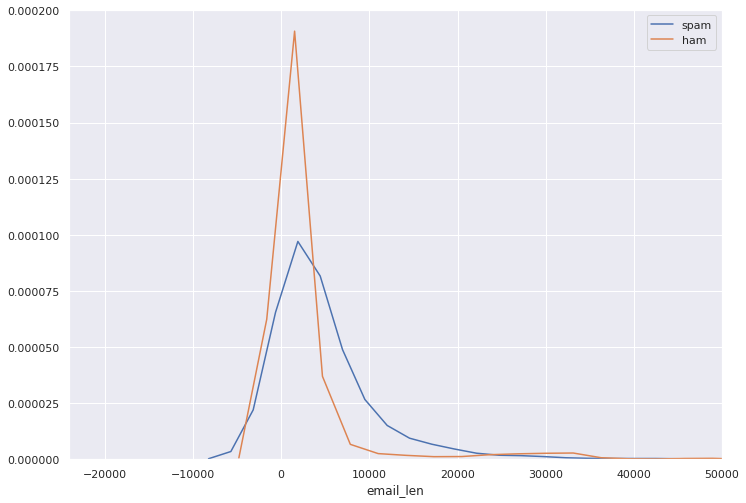

In [123]:
#Comments
#As you can see in the plot below that, the spam curbe is skewed towards right meaning most email 
#that are classified as spam tends to be longer than ham emails. This stats that the spam emails tends to be more wordier
#than the ham emails
dframe2 = train.copy()
dframe2['email_len'] = train['email'].str.len()
sns.distplot(dframe2[dframe2['spam']==1]['email_len'],hist = False,label ='spam' )
sns.distplot(dframe2[dframe2['spam']==0]['email_len'],hist = False,label ='ham' )
plt.xlim(right = 50000)

### Question 9: ROC Curve

In most cases we won't be able to get no false positives and no false negatives, so we have to compromise. For example, in the case of cancer screenings, false negatives are comparatively worse than false positives — a false negative means that a patient might not discover a disease until it's too late to treat, while a false positive means that a patient will probably have to take another screening.

Recall that logistic regression calculates the probability that an example belongs to a certain class. Then, to classify an example we say that an email is spam if our classifier gives it $\ge 0.5$ probability of being spam. However, *we can adjust that cutoff*: we can say that an email is spam only if our classifier gives it $\ge 0.7$ probability of being spam, for example. This is how we can trade off false positives and false negatives.

The ROC curve shows this trade off for each possible cutoff probability. In the cell below, plot an ROC curve for your final classifier (the one you use to make predictions for Kaggle). Refer to the Lecture 22 notebook or Section 17.7 of the course text to see how to plot an ROC curve.



<!--
BEGIN QUESTION
name: q9
manual: True
points: 3
-->
<!-- EXPORT TO PDF -->

Text(0, 0.5, 'Sensitivity')

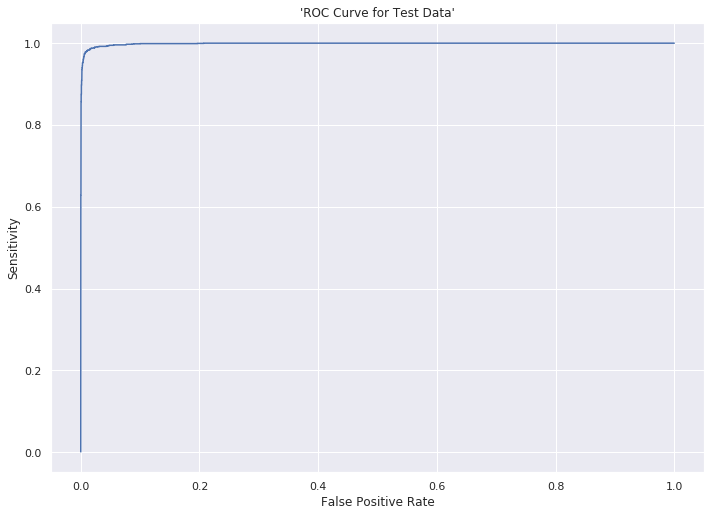

In [124]:
from sklearn.metrics import roc_curve

modelcv_probabilities = modelcv.predict_proba(X_train1)[:, 1]
false_positive_rate_values, sensitivity_values, thresholds = roc_curve(Y_train1, modelcv_probabilities, pos_label=1)
# Note that you'll want to use the .predict_proba(...) method for your classifier
# instead of .predict(...) so you get probabilities, not classes
plt.plot(false_positive_rate_values,sensitivity_values)
plt.title("'ROC Curve for Test Data'")
plt.xlabel("False Positive Rate")
plt.ylabel("Sensitivity")

# Question 10: Submitting to Kaggle

The following code will write your predictions on the test dataset to a CSV, which you can submit to Kaggle. You may need to modify it to suit your needs.

Save your predictions in a 1-dimensional array called `test_predictions`. *Even if you are not submitting to Kaggle, please make sure you've saved your predictions to `test_predictions` as this is how your score for this question will be determined.*

Remember that if you've performed transformations or featurization on the training data, you must also perform the same transformations on the test data in order to make predictions. For example, if you've created features for the words "drug" and "money" on the training data, you must also extract the same features in order to use scikit-learn's `.predict(...)` method.

You should submit your CSV files to https://www.kaggle.com/c/ds100fa19

*The provided tests check that your predictions are in the correct format, but you must submit to Kaggle to evaluate your classifier accuracy.*

<!--
BEGIN QUESTION
name: q10
points: 15
-->

In [125]:
test_predictions = modelcv.predict(design_matrix_converter(test_word,test['email']))

In [126]:
ok.grade("q10");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



The following saves a file to submit to Kaggle.

In [127]:
from datetime import datetime

# Assuming that your predictions on the test set are stored in a 1-dimensional array called
# test_predictions. Feel free to modify this cell as long you create a CSV in the right format.

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": test['id'], 
    "Class": test_predictions,
}, columns=['Id', 'Class'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Kaggle for scoring.')

Created a CSV file: submission_2019-11-24T22:14:47.csv.
You may now upload this CSV file to Kaggle for scoring.


# Submit
Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output.
**Please save before submitting!**

<!-- EXPECT 9 EXPORTED QUESTIONS -->

In [128]:
# Save your notebook first, then run this cell to submit.
import jassign.to_pdf
jassign.to_pdf.generate_pdf('proj2.ipynb', 'proj2.pdf')
ok.submit()

Generating PDF...
Saved proj2.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'proj2.ipynb'.
Submit... 100% complete
Submission successful for user: freedomcomets@berkeley.edu
URL: https://okpy.org/cal/data100/fa19/proj2/submissions/r2om3p

